# These plots are of a sample of optical non-counterparts

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.table import Table

from astropy.coordinates import SkyCoord
import astropy.units as u

from nested_pandas import read_parquet

In [2]:
pd.set_option('display.max_columns', 100)
CAT_COLORS = {'2SXPS':'tab:blue', '4XMMDR14':'tab:orange', 'CSC2.1':'tab:green', 'eRASS1':'tab:red', 'XMMSL3':'tab:purple'}
COLORS = {
    "u": "#56b4e9",
    "g": "#009e73",
    "r": "#f0e442",
    "i": "#cc79a7",
    "z": "#d55e00",
    "y": "#0072b2",
}

In [3]:
df_X = pd.read_csv('../data/xray_in_DP1_patches.csv')

In [4]:
obj = read_parquet('../data/obj_dp1_xmatch_control_added.parquet')
dia = read_parquet('../data/dia_dp1_xmatch_control_added.parquet')

## Plot positional error by catalog

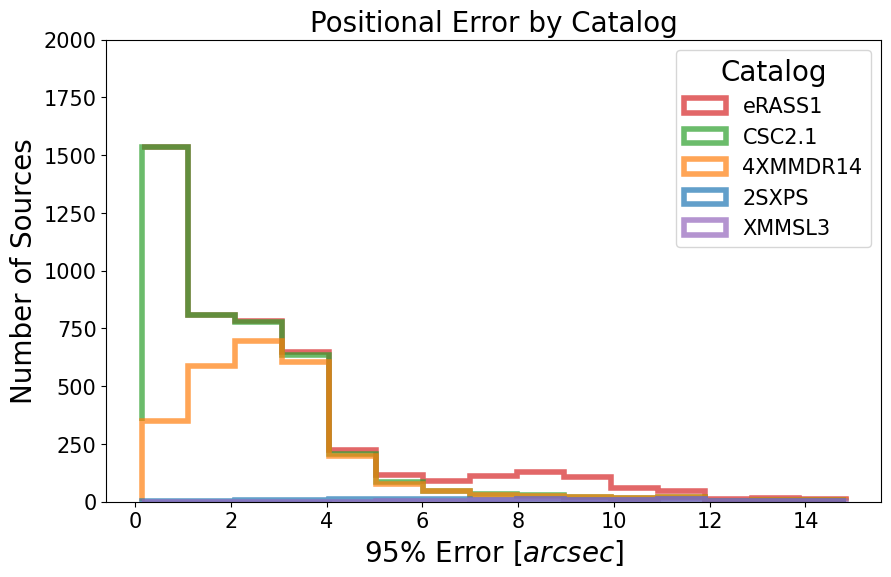

In [5]:
plt.rcParams.update({
    'font.size': 20,          # Double the default (usually ~10)
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'legend.fontsize': 15
})

# Group values by category
catalogs = ['XMMSL3', '2SXPS', '4XMMDR14', 'CSC2.1', 'eRASS1']
colors = [CAT_COLORS[cat] for cat in catalogs]
grouped_errors = [df_X[df_X['cat'] == g]['e_pos_95'] for g in catalogs]

# Plot stacked histogram
plt.figure(figsize=(10,6))
plt.hist(grouped_errors, 
         bins=15, 
         stacked=True, 
         label=catalogs, color=colors,
         alpha=0.7, histtype='step',  linewidth=4)

plt.xlabel('95% Error [$arcsec$]')
plt.ylabel('Number of Sources')
plt.title('Positional Error by Catalog')
plt.legend(title='Catalog')
plt.ylim([0, 2000])
plt.savefig('../plots/Error_by_catalog.png')
plt.show()

Text(0, 0.5, '     ')

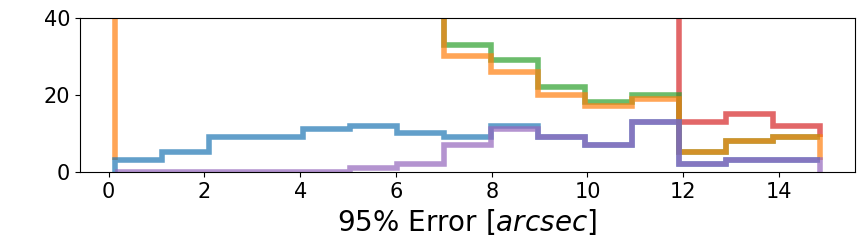

In [6]:
plt.figure(figsize=(10,2))
plt.hist(grouped_errors, 
         bins=15, 
         stacked=True, 
         label=catalogs, color=colors,
         alpha=0.7, histtype='step',  linewidth=4)
plt.ylim([0,40])
plt.xlabel('95% Error [$arcsec$]')
plt.ylabel('     ')

## Plot $R_{95}$ by field

In [7]:
def plot_errors_by_col(df, ax, col):
    # Group values by catalog
    groups = df[col].unique()
    # ['2SXPS', '4XMMDR14', 'CSC2.1', 'XMMSL3', 'eRASS1']
    grouped_values = [df[df['cat_X'] == c]['e_pos_95_X'] for c in groups]
    
    # Plot stacked histogram
    ax.hist(grouped_values, 
             bins=15, 
             stacked=True, 
             label=groups, 
             alpha=0.7, histtype='step',  linewidth=2)


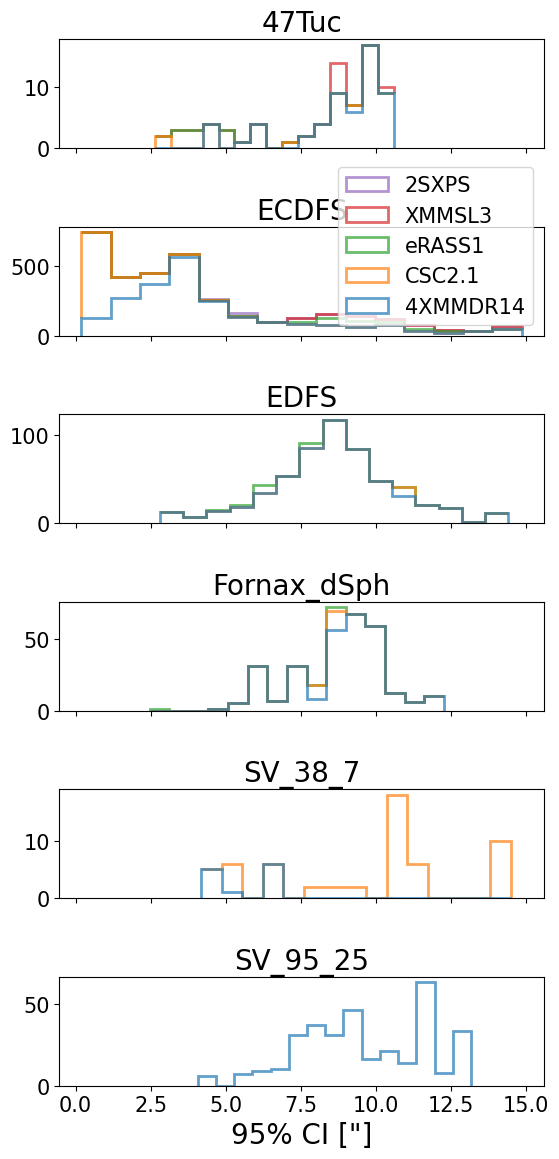

In [8]:
fig, axs = plt.subplots(nrows=6, sharex=True, figsize=(6,12))
for i, field in enumerate(['47Tuc', 'ECDFS', 'EDFS', 'Fornax_dSph', 'SV_38_7', 'SV_95_25']):
    matches_field = obj.query(f'field_X == "{field}"')[['cat_X', 'e_pos_95_X']]
    plot_errors_by_col(matches_field, ax=axs[i], col='cat_X')
    axs[i].set_title(field)
    if i == 1:
        axs[i].legend()
# plt.suptitle('Histogram of X-ray Objects by the Number of Matches')
plt.xlabel('95% CI ["]')
# plt.legend()
plt.tight_layout()

## Plot number of sources per catalog in each field

In [9]:
gb = df_X.groupby(['field', 'cat'])['ra'].count()

gb = gb.reset_index()
gb.rename({'field': 'DP1 Field', 'cat': 'Catalog', 'ra': 'Number of Sources'}, axis=1, inplace=True)

pivot = pd.pivot_table(gb, index=['DP1 Field'], columns=['Catalog'])
pivot.replace(np.nan, 0, inplace=True)
pivot = pivot['Number of Sources']
pivot

Catalog,2SXPS,4XMMDR14,CSC2.1,XMMSL3,eRASS1
DP1 Field,,,,,
47Tuc,33.0,49.0,473.0,11.0,52.0
ECDFS,10.0,2344.0,1073.0,30.0,40.0
EDFS,10.0,0.0,0.0,3.0,199.0
Fornax_dSph,0.0,184.0,0.0,5.0,85.0
SV_38_7,6.0,0.0,0.0,9.0,0.0
SV_95_25,0.0,0.0,0.0,0.0,80.0


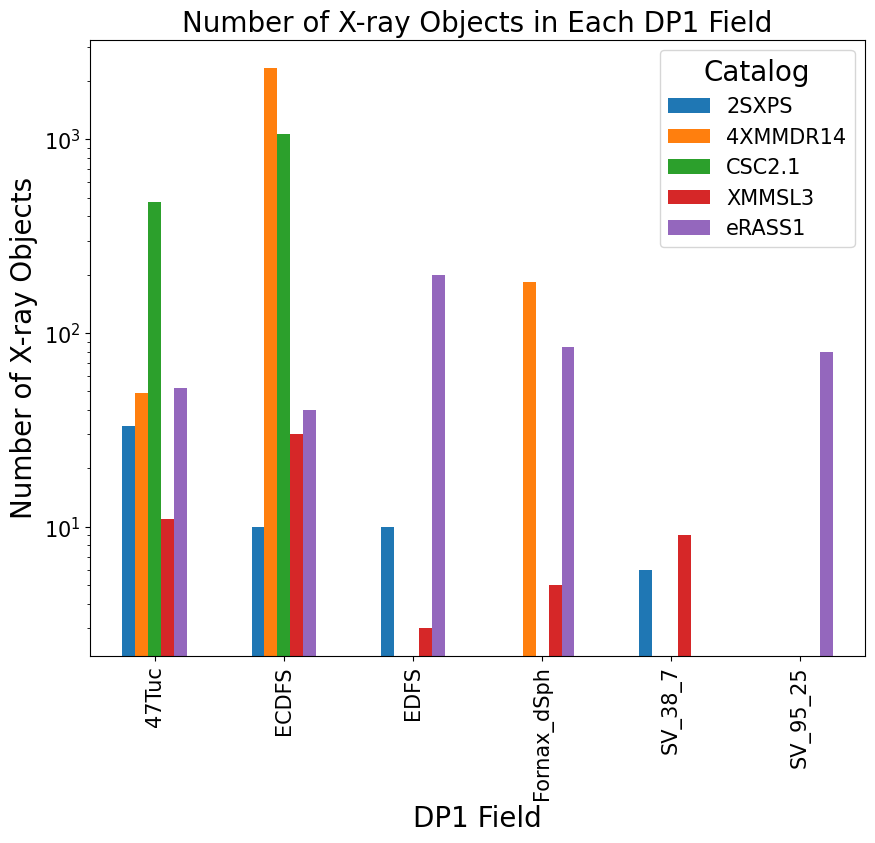

In [10]:
ax = pivot.plot.bar(figsize=(10,8))
ax.set_ylabel('Number of X-ray Objects')
ax.set_xlabel('DP1 Field')
ax.set_title('Number of X-ray Objects in Each DP1 Field')
ax.set_yscale('log')
# plt.savefig('../plots/xray_per_field_log.png')

plt.savefig('../plots/xray_per_field.png')

## Plot counterparts spatially

checks:  22 22
checks:  2101 2101
checks:  123 123
checks:  54 54
checks:  14 14
checks:  56 56


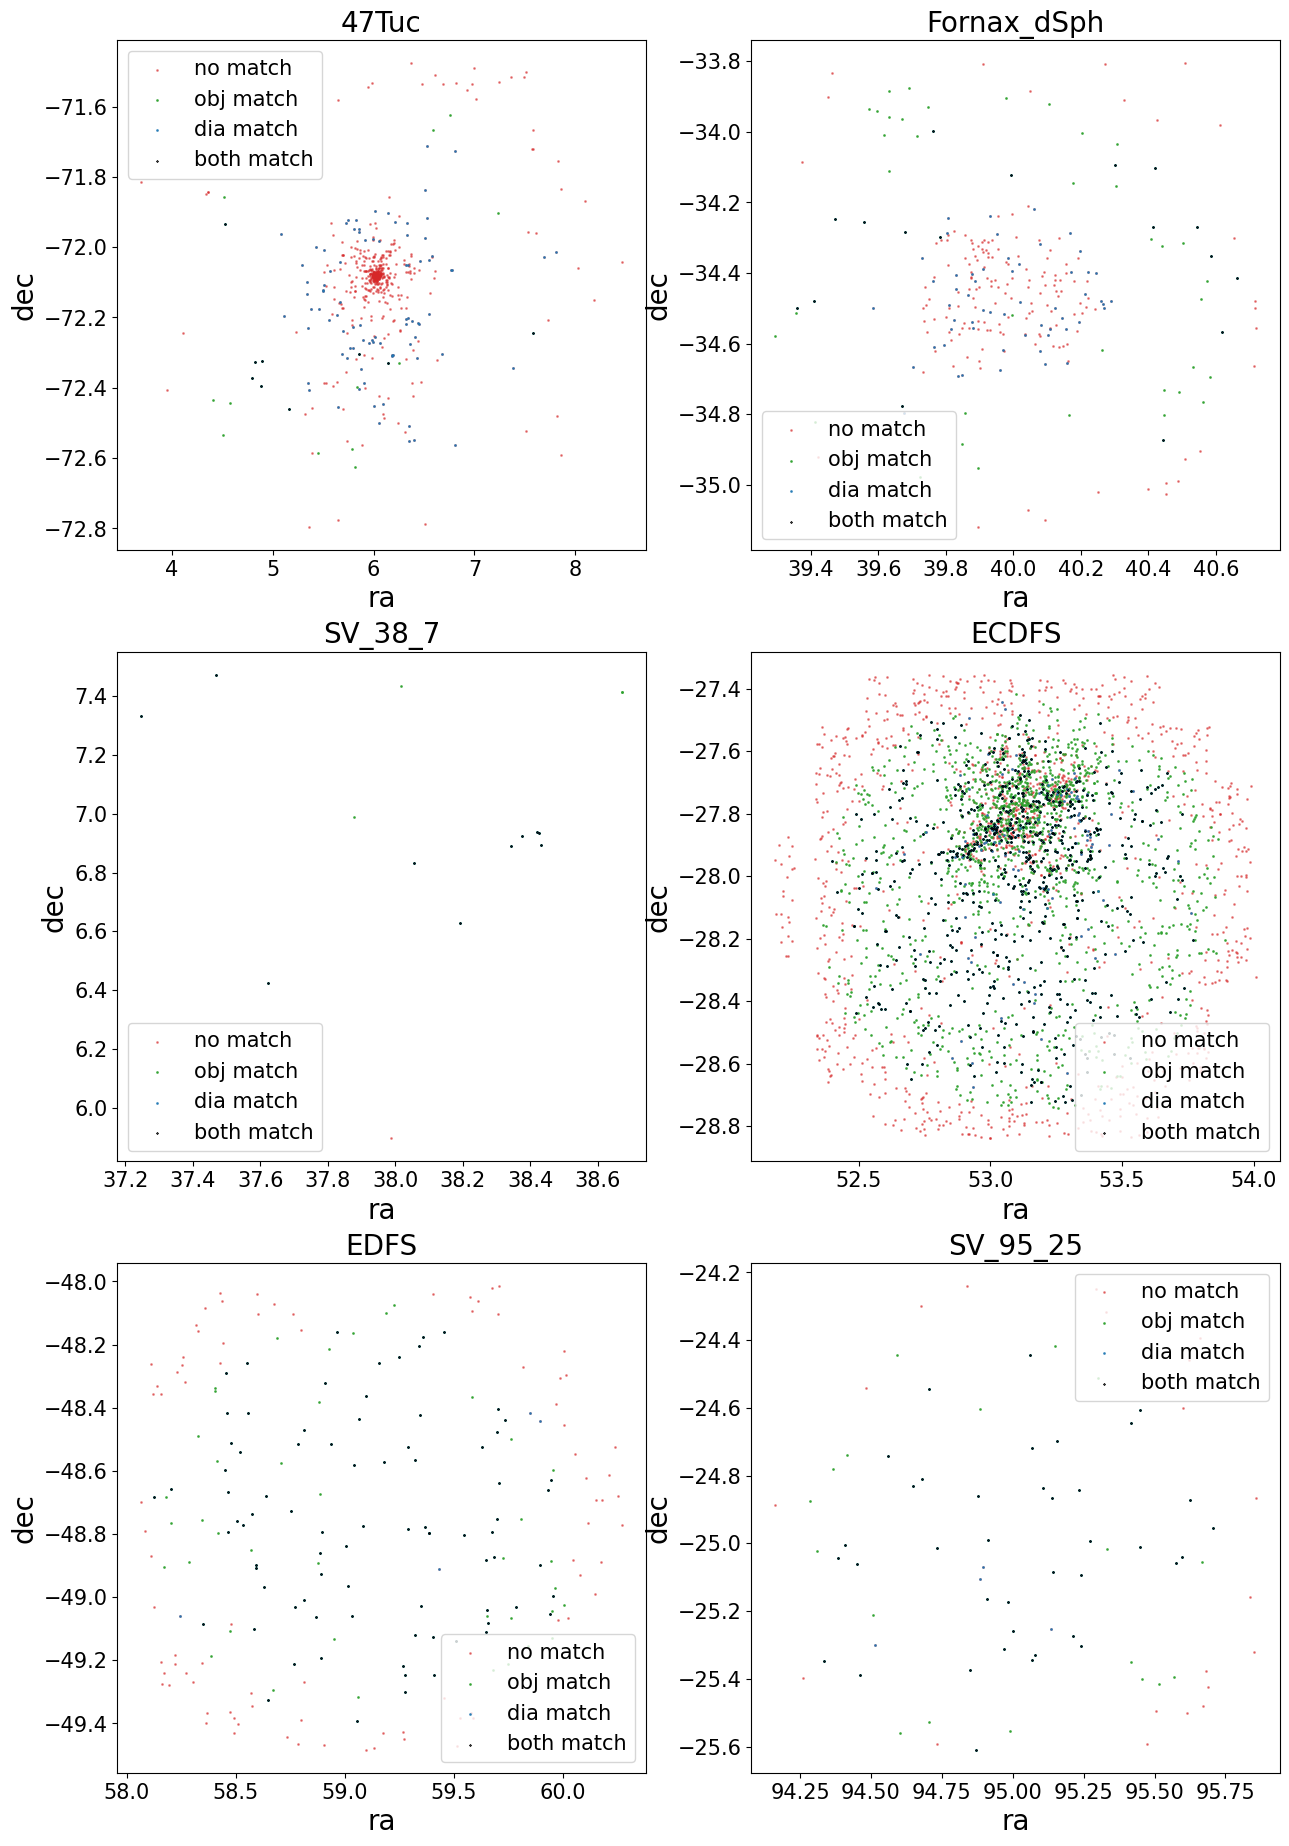

In [11]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 22.5))
for i, field in enumerate(['47Tuc', 'ECDFS', 'EDFS', 'Fornax_dSph', 'SV_38_7', 'SV_95_25']):
    row = i%3
    col = i%2
    # observed = ind_df[ind_df['DP1_flag']]
    ind_field = df_X.query(f'field == "{field}"')
    matches_field = obj.query(f'field_X == "{field}"')
    
    print("checks: ", len(matches_field['name_X'].unique()), sum(ind_field['obj_flag']))
    
    ind_field[~ind_field['obj_flag']].plot.scatter(x='ra', y='dec', s=1, ax=axs[row, col],alpha=.5, color='tab:red', label='no match')
    ind_field[ind_field['obj_flag']].plot.scatter(x='ra', y='dec', s=1, ax=axs[row, col],alpha=.8, color='tab:green', label='obj match')
    ind_field[ind_field['dia_flag']].plot.scatter(x='ra', y='dec', s=1, alpha=.8, ax=axs[row, col], color='tab:blue', label='dia match')
    ind_field[(ind_field['dia_flag'] & ind_field['obj_flag'])].plot.scatter(x='ra', y='dec', s=1, alpha=.8, ax=axs[row, col], marker='x', color='k', label='both match')

    axs[row,col].set_title(field)

## Plot duplicates

Text(0.5, 0, 'Num Counterparts in 95% Error Circle')

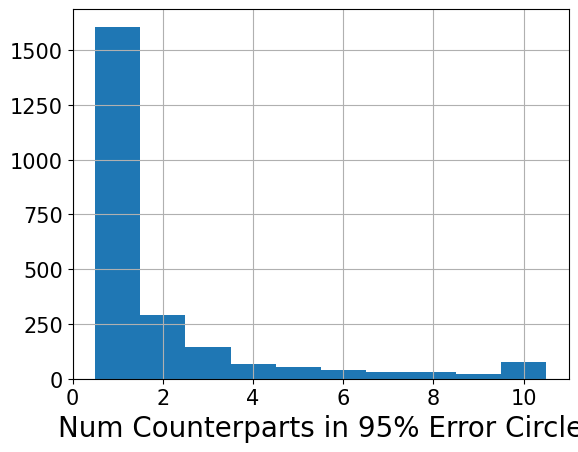

In [12]:
n_matches_xray = obj.groupby('name_X')['objectId'].count()
n_matches_xray.value_counts()
n_matches_xray.hist(bins=np.linspace(.5, 10.5, 11))
plt.xlabel('Num Counterparts in 95% Error Circle')

Text(0.5, 0.98, 'Num Counterparts in 95% Error Circle')

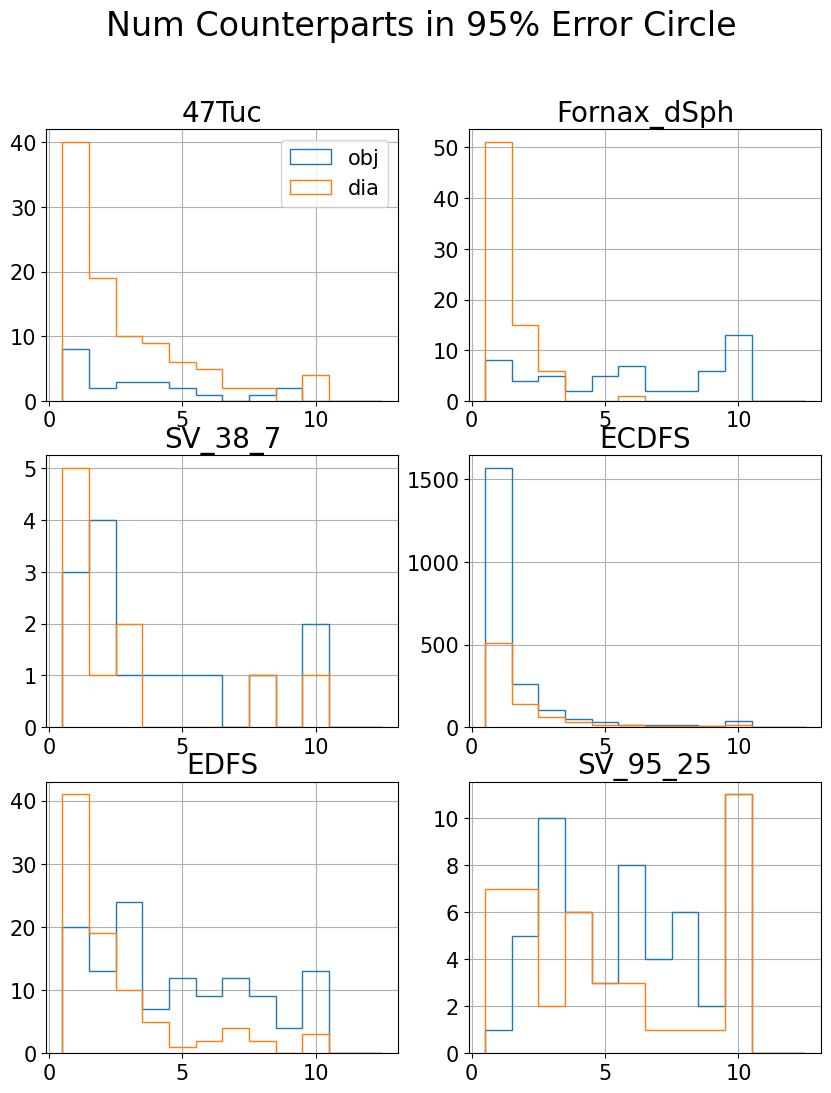

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))
for i, field in enumerate(['47Tuc', 'ECDFS', 'EDFS', 'Fornax_dSph', 'SV_38_7', 'SV_95_25']):
    row = i%3
    col = i%2
    n_matches_field_obj = obj.query(f'field_X == "{field}"').groupby('name_X')['objectId'].count()
    n_matches_field_dia = dia.query(f'field_X == "{field}"').groupby('name_X')['diaObjectId'].count()
    n_matches_field_obj.hist(bins=np.linspace(.5, 12.5, 13), ax=axs[row,col], histtype='step', label='obj')
    n_matches_field_dia.hist(bins=np.linspace(.5, 12.5, 13), ax=axs[row,col], histtype='step', label='dia')
    axs[row,col].set_title(field)
    if i==0:
        axs[row,col].legend()
plt.suptitle('Num Counterparts in 95% Error Circle')

## Plot number of candidate counterparts for each x-ray object by catalog

### matches to object table

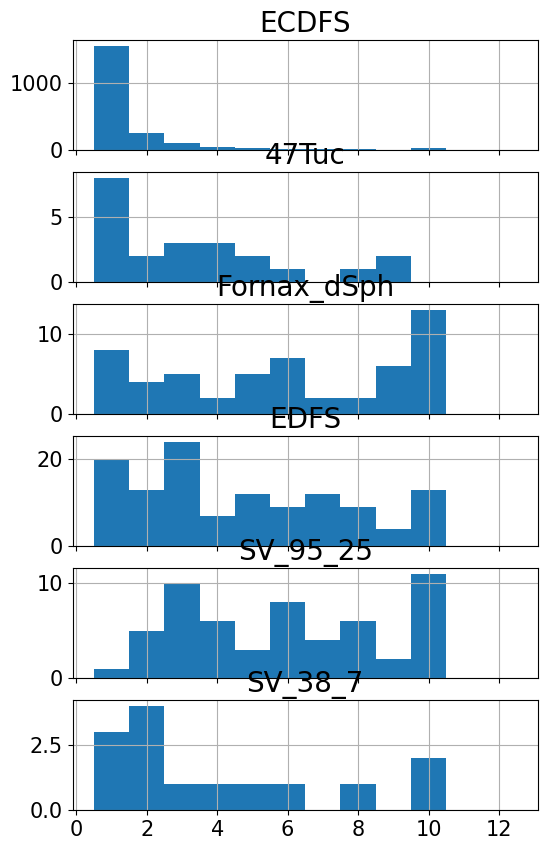

In [14]:
fig, axs = plt.subplots(nrows=6, sharex=True, figsize=(6,10))
for i, field in enumerate(['ECDFS', '47Tuc', 'Fornax_dSph', 'EDFS', 'SV_95_25', 'SV_38_7']):
    n_matches_field = obj.query(f'field_X == "{field}"').groupby('name_X')['objectId'].count()
    n_matches_field.hist(bins=np.linspace(.5, 12.5, 13), ax=axs[i])
    axs[i].set_title(field)

### matches to diaObject table

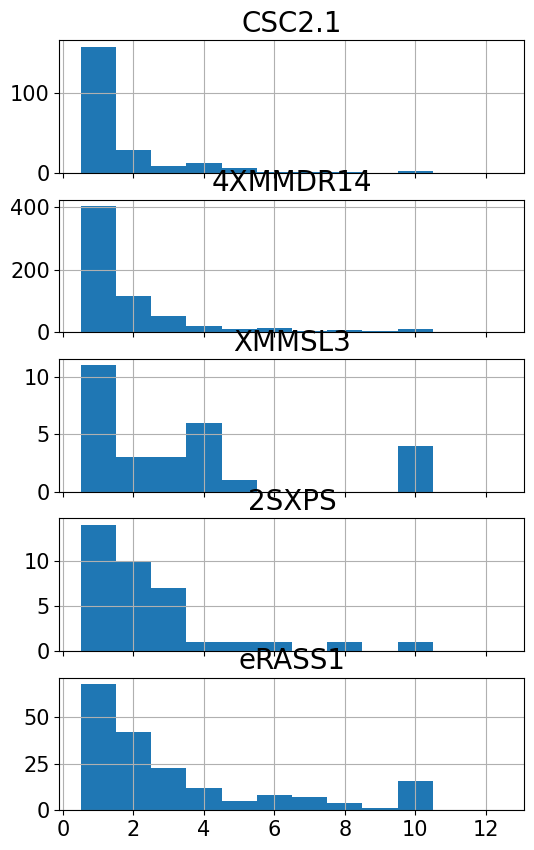

In [15]:
fig, axs = plt.subplots(nrows=5, sharex=True, figsize=(6,10))
for i, cat in enumerate(['CSC2.1', '4XMMDR14', 'XMMSL3', '2SXPS', 'eRASS1']):
    n_matches_field = dia.query(f'cat_X == "{cat}"').groupby('name_X')['diaObjectId'].count()
    n_matches_field.hist(bins=np.linspace(.5, 12.5, 13), ax=axs[i])
    axs[i].set_title(cat)

## Plot Fx/Fopt

/astro/users/smcampos/.conda/envs/lsdb_v06/lib/python3.12/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in log10
  return getattr(ufunc, method)(*new_inputs, **kwargs)
/astro/users/smcampos/.conda/envs/lsdb_v06/lib/python3.12/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: divide by zero encountered in log10
  return getattr(ufunc, method)(*new_inputs, **kwargs)


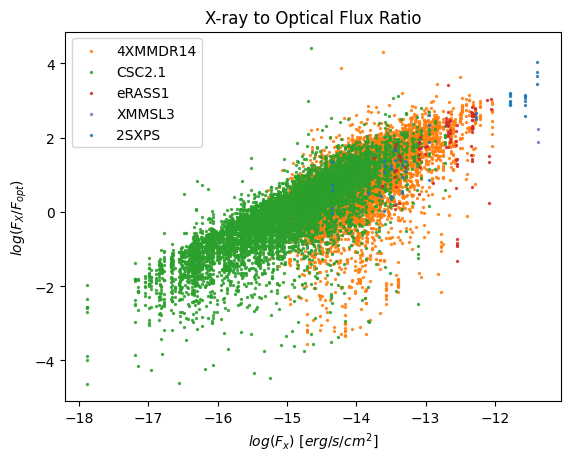

In [5]:
# Plot points with colors based on catalog
for i, cat in enumerate(['4XMMDR14', 'CSC2.1', 'eRASS1', 'XMMSL3', '2SXPS',]):
    mask = np.array(obj['cat_X']) == cat
    plt.scatter(np.log10(obj['F_X'][mask]), np.log10(obj['F_X'][mask])-np.log10(obj['F_opt'][mask]), marker='.', label=cat, alpha=0.8, s=8, color=CAT_COLORS[cat])
   
# Labels and title
plt.xlabel('$log(F_x)~[erg/s/cm^2]$')
plt.ylabel('$log(F_X/F_{opt})$')

plt.title("X-ray to Optical Flux Ratio")

# Legend
plt.legend()

# plt.savefig('plots/Fx_to_Fopt.png')
# Show plot
plt.show()

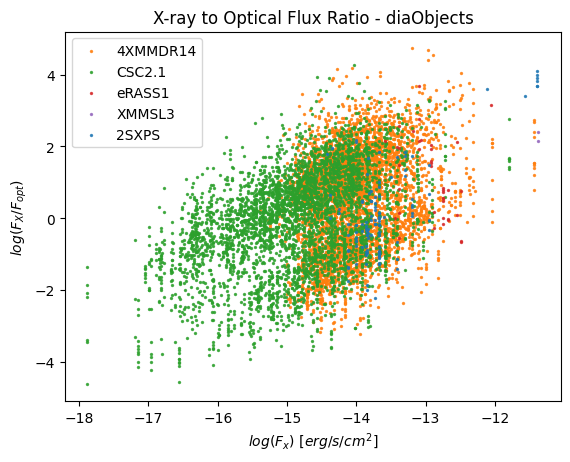

In [6]:
# Plot points with colors based on catalog
for i, cat in enumerate(['4XMMDR14', 'CSC2.1', 'eRASS1', 'XMMSL3', '2SXPS',]):
    mask = np.array(dia['cat_X']) == cat
    plt.scatter(np.log10(dia['F_X'][mask]), np.log10(dia['F_X'][mask])-np.log10(dia['F_opt'][mask]), marker='.', label=cat, alpha=0.8, s=8, color=CAT_COLORS[cat])
   
# Labels and title
plt.xlabel('$log(F_x)~[erg/s/cm^2]$')
plt.ylabel('$log(F_X/F_{opt})$')

plt.title("X-ray to Optical Flux Ratio - diaObjects")

# Legend
plt.legend()

# plt.savefig('plots/Fx_to_Fopt.png')
# Show plot
plt.show()

### Plot flux ratios with objects in light grey under diaObject flux ratios

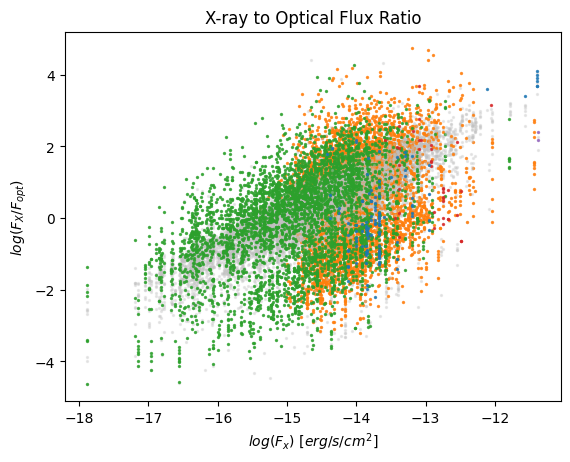

In [7]:
# Plot points with colors based on catalog
for i, cat in enumerate(['4XMMDR14', 'CSC2.1', 'eRASS1', 'XMMSL3', '2SXPS',]):
    mask = np.array(obj['cat_X']) == cat
    mask_dia = np.array(dia['cat_X']) == cat
    plt.scatter(np.log10(obj['F_X'][mask]), np.log10(obj['F_X'][mask])-np.log10(obj['F_opt'][mask]), marker='.', label=cat, alpha=0.3, s=8, color='silver')
    plt.scatter(np.log10(dia['F_X'][mask_dia]), np.log10(dia['F_X'][mask_dia])-np.log10(dia['F_opt'][mask_dia]), marker='.', label=cat, alpha=0.8, s=8, color=CAT_COLORS[cat])
   
# Labels and title
plt.xlabel('$log(F_x)~[erg/s/cm^2]$')
plt.ylabel('$log(F_X/F_{opt})$')

plt.title("X-ray to Optical Flux Ratio")

# Legend
# plt.legend()

# plt.savefig('plots/Fx_to_Fopt.png')
# Show plot
plt.show()

/astro/users/smcampos/.conda/envs/lsdb_v06/lib/python3.12/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in log10
  return getattr(ufunc, method)(*new_inputs, **kwargs)
/astro/users/smcampos/.conda/envs/lsdb_v06/lib/python3.12/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: divide by zero encountered in log10
  return getattr(ufunc, method)(*new_inputs, **kwargs)


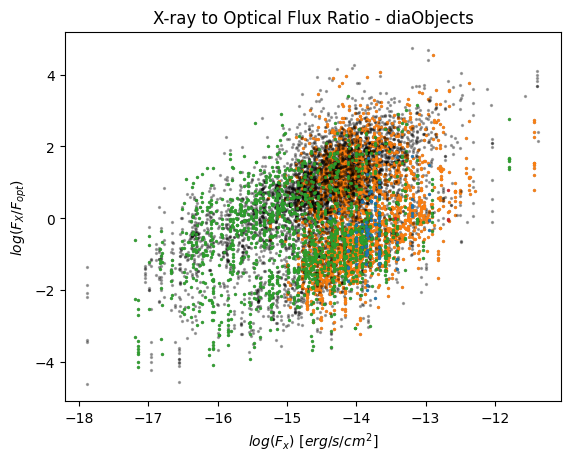

In [8]:
# plot only diaObjects with no object counterpart (mostly crowded fields where detection fails on the coadd) in color
dia_no_obj = dia[~dia['obj_flag_X']]

for i, cat in enumerate(['4XMMDR14', 'CSC2.1', 'eRASS1', 'XMMSL3', '2SXPS',]):
    mask = np.array(dia_no_obj['cat_X']) == cat
    mask_dia = np.array(dia['cat_X']) == cat
    plt.scatter(np.log10(dia['F_X'][mask_dia]), np.log10(dia['F_X'][mask_dia])-np.log10(dia['F_opt'][mask_dia]), marker='.', label=cat, alpha=0.3, s=8, color='k')
    plt.scatter(np.log10(dia_no_obj['F_X'][mask]), np.log10(dia_no_obj['F_X'][mask])-np.log10(dia_no_obj['F_opt'][mask]), marker='.', label=cat, alpha=0.8, s=8, color=CAT_COLORS[cat])

# Labels and title
plt.xlabel('$log(F_x)~[erg/s/cm^2]$')
plt.ylabel('$log(F_X/F_{opt})$')

plt.title("X-ray to Optical Flux Ratio - diaObjects")

# Legend
# plt.legend()

# plt.savefig('plots/Fx_to_Fopt.png')
# Show plot
plt.show()

## Plot stetsonJs

Text(0.5, 0, 'StetsonJ')

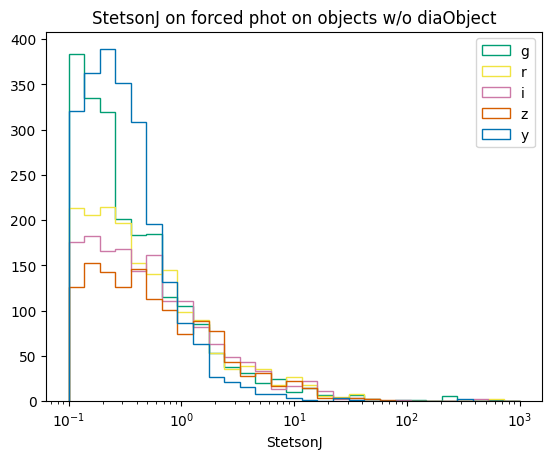

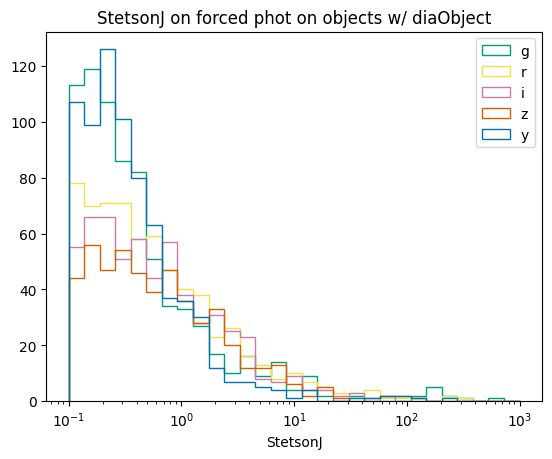

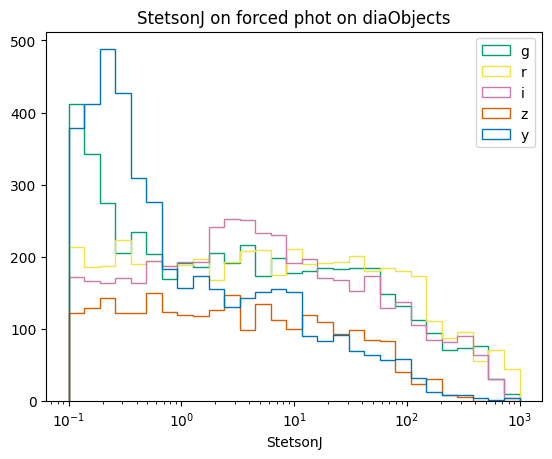

In [16]:
for band in 'grizy':
    col = f'{band}_psfFluxForcedStetsonJ'
    plt.hist(obj[~obj['dia_flag_X']][col], bins=np.logspace(-1, 3, 30), histtype='step', color=COLORS[band], label=band)
    plt.xscale('log')
plt.legend()
plt.xlabel('StetsonJ')
plt.title('StetsonJ on forced phot on objects w/o diaObject')

plt.figure()
for band in 'grizy':
    col = f'{band}_psfFluxForcedStetsonJ'
    plt.hist(obj[obj['dia_flag_X']][col], bins=np.logspace(-1, 3, 30), histtype='step', color=COLORS[band], label=band)
    plt.xscale('log')
plt.legend()
plt.title('StetsonJ on forced phot on objects w/ diaObject')
plt.xlabel('StetsonJ')

plt.figure()
for band in 'grizy':
    col = f'{band}_psfFluxForcedStetsonJ'
    plt.hist(dia[col], bins=np.logspace(-1, 3, 30), histtype='step', color=COLORS[band], label=band)
    plt.xscale('log')
plt.legend()
plt.title('StetsonJ on forced phot on diaObjects')
plt.xlabel('StetsonJ')

Text(0.5, 0, 'StetsonJ')

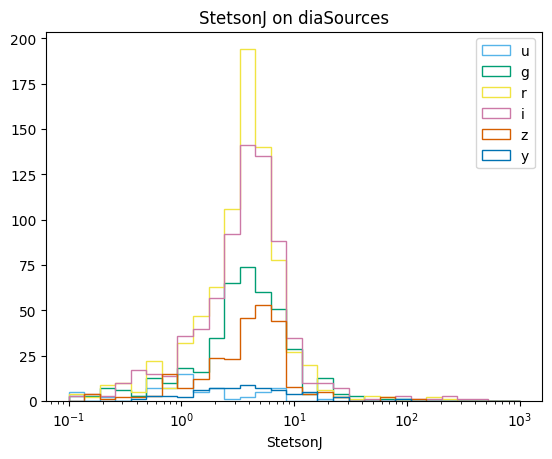

In [10]:
plt.figure()
for band in 'ugrizy':
    plt.hist(dia[f'{band}_psfFluxStetsonJ'], bins=np.logspace(-1, 3, 30), histtype='step', color=COLORS[band], label=band)
    plt.xscale('log')
plt.legend()
plt.title('StetsonJ on diaSources')
plt.xlabel('StetsonJ')

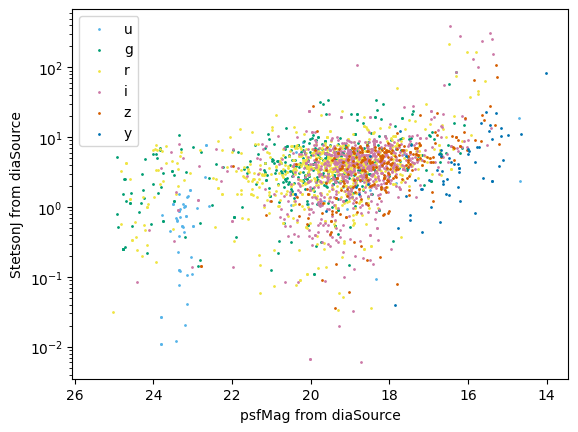

In [11]:
for band in 'ugrizy':
    plt.scatter(dia[f"{band}_psfMag"], dia[f'{band}_psfFluxStetsonJ'], color=COLORS[band], label=band, s=1)
    plt.yscale('log')
plt.gca().invert_xaxis()
plt.xlabel('psfMag from diaSource')
plt.ylabel('StetsonJ from diaSource')
plt.legend()

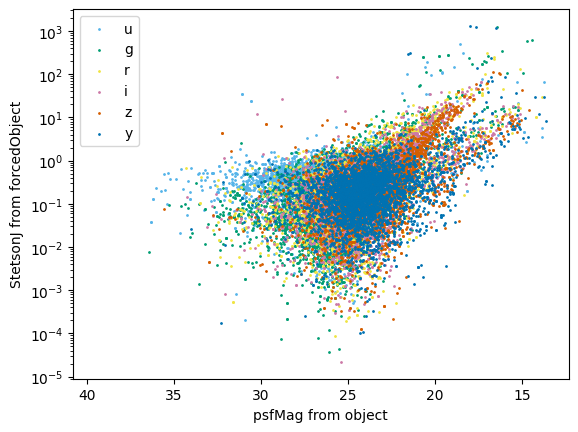

In [12]:
for band in 'ugrizy':
    col = f'{band}_psfFluxForcedStetsonJ'
    plt.scatter(obj[f"{band}_psfMag"], obj[col], color=COLORS[band], label=band, s=1)
    plt.yscale('log')
plt.gca().invert_xaxis()
plt.xlabel('psfMag from object')
plt.ylabel('StetsonJ from forcedObject')
plt.legend()

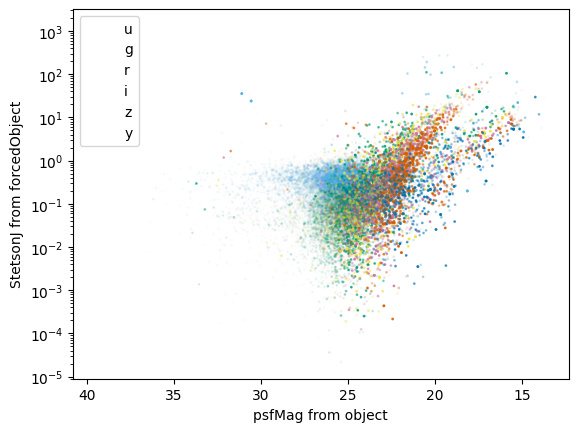

In [13]:
for band in 'ugrizy':
    col = f'{band}_psfFluxForcedStetsonJ'
    plt.scatter(obj[f"{band}_psfMag"], obj[col], color=COLORS[band], label=band, s=1, 
                alpha=(np.pow(obj[f"{band}_nForced"].replace(np.nan, 0), 2) / 
                       np.pow(obj[f"{band}_nForced"].replace(np.nan, 0), 2).max())) # opacity ~ nObs ** 2 -> [0, 1]
    plt.yscale('log')
plt.gca().invert_xaxis()
plt.xlabel('psfMag from object')
plt.ylabel('StetsonJ from forcedObject')
plt.legend()

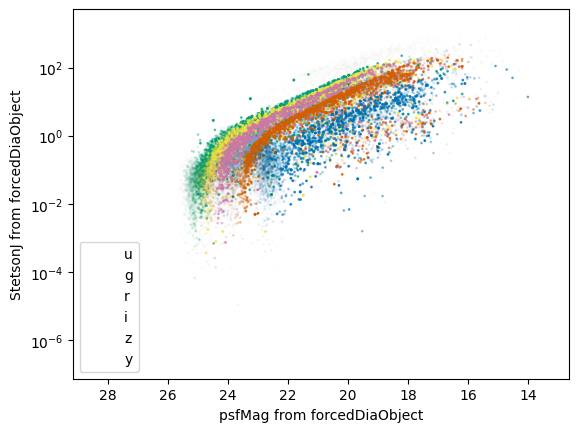

In [14]:
for band in 'ugrizy':
    col = f'{band}_psfFluxForcedStetsonJ'
    plt.scatter(dia[f"{band}_psfMag"], dia[col], color=COLORS[band], label=band, s=1, 
                alpha=(np.pow(dia[f"{band}_nForced"].replace(np.nan, 0), 2) /
                       np.pow(dia[f"{band}_nForced"].replace(np.nan, 0), 2).max()))
    plt.yscale('log')
plt.gca().invert_xaxis()
plt.xlabel('psfMag from forcedDiaObject')
plt.ylabel('StetsonJ from forcedDiaObject')
plt.legend()

# Number densities of sources

In [26]:
dens = pd.read_csv('../data/densities.csv')


#### Plot residuals between annulus number density and density within outer circle
We expect many residuals centered at zero, but also a slight bump in negative direction, because the annulus number density, which excludes the counterpart, should be lower than the total density in the circle

<Axes: >

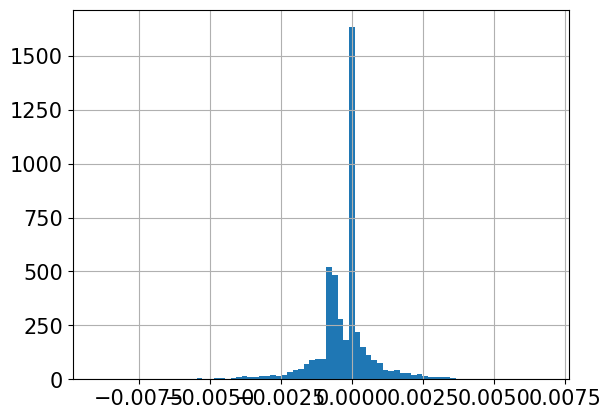

In [27]:
resids = dens['N_asec2'] - (dens['n_obj_outer'] / dens['area_outer_asec2'])
resids.hist(bins=80)

### densities per field

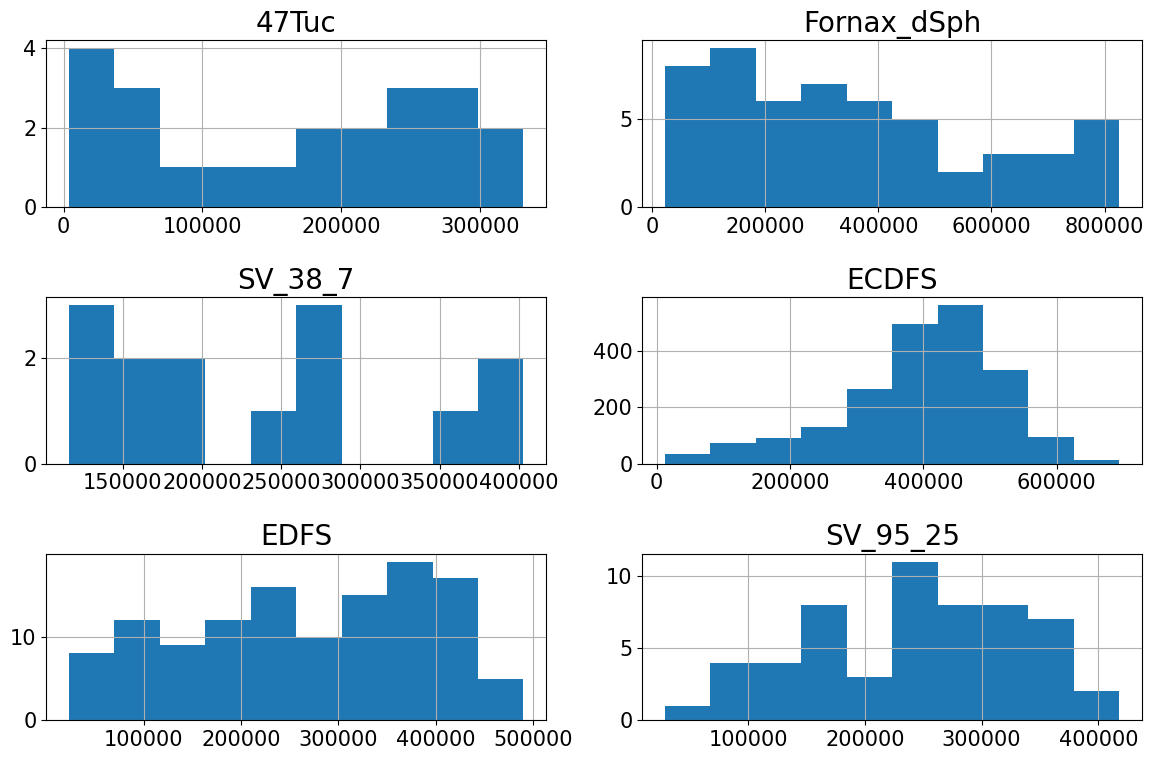

In [28]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=False, figsize=(12,8))
for i, field in enumerate(['47Tuc', 'ECDFS', 'EDFS', 'Fornax_dSph', 'SV_38_7', 'SV_95_25']):
    row = i%3
    col = i%2
    sub = dens[dens['obj_flag']].query(f'field == "{field}"')['N_deg2']
    sub.hist(ax=axs[row,col])
    axs[row,col].set_title(field)
plt.tight_layout()

# Plot reliability of each counterpart

### obj matches

In [29]:
obj['norm_dist'] = obj['_dist_arcsec'] / obj['e_pos_1sig_X']
obj['reliability'] = np.exp(-np.pi * obj['_dist_arcsec'] ** 2 * dens['N_asec2'])

Text(0.5, 0, 'Reliability')

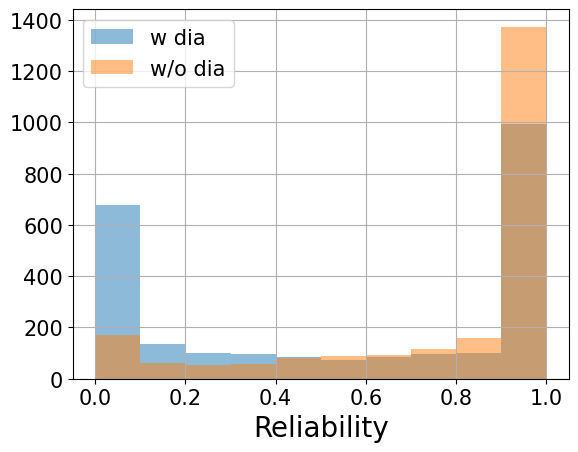

In [30]:
fig, ax = plt.subplots()
obj[obj['dia_flag_X']]['reliability'].hist(ax=ax, alpha=.5, label='w dia')
obj[~obj['dia_flag_X']]['reliability'].hist(ax=ax, alpha=.5, label='w/o dia')
plt.legend()
plt.xlabel('Reliability')

### Plot reliability of closest counterpart

In [31]:
obj_closest = obj.sort_values('norm_dist', ascending=True).drop_duplicates('name_X', keep='first')

In [32]:
len(obj_closest)

2370

Text(0.5, 0, 'Reliability of closest counterpart')

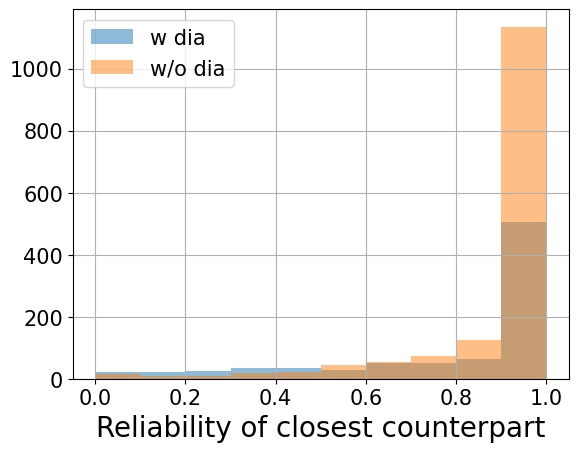

In [33]:
fig, ax = plt.subplots()
obj_closest[obj_closest['dia_flag_X']]['reliability'].hist(ax=ax, alpha=.5, label='w dia')
obj_closest[~obj_closest['dia_flag_X']]['reliability'].hist(ax=ax, alpha=.5, label='w/o dia')
plt.legend()
plt.xlabel('Reliability of closest counterpart')

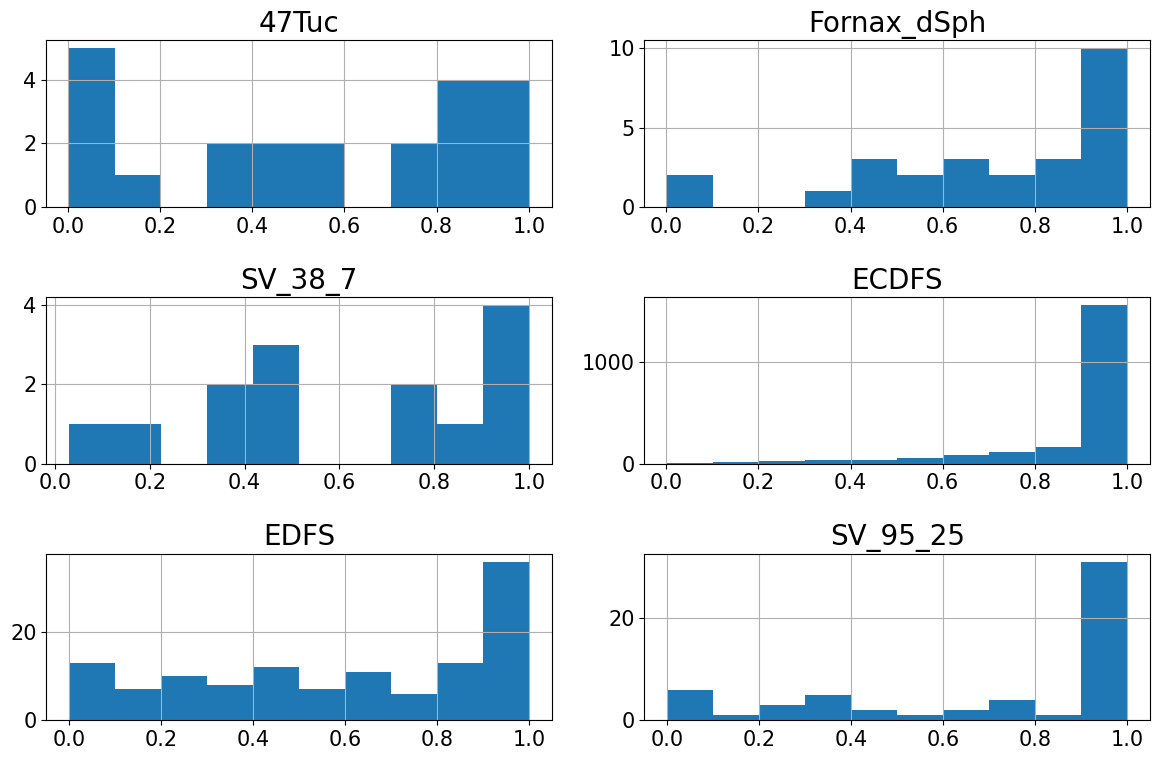

In [34]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=False, figsize=(12,8))
for i, field in enumerate(['47Tuc', 'ECDFS', 'EDFS', 'Fornax_dSph', 'SV_38_7', 'SV_95_25']):
    row = i%3
    col = i%2
    sub = obj_closest.query(f'field_X == "{field}"')['reliability']
    sub.hist(ax=axs[row,col])
    axs[row,col].set_title(field)
plt.tight_layout()

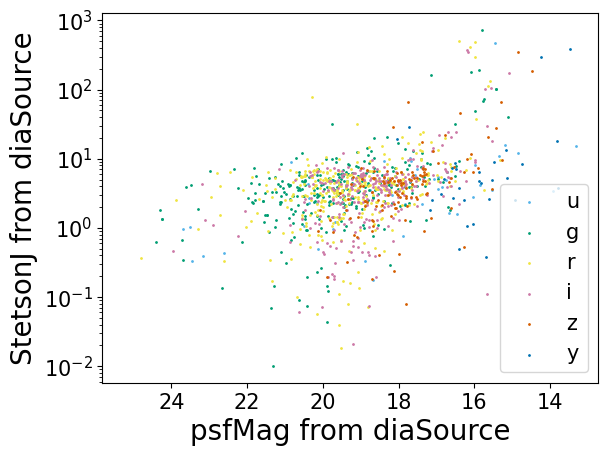

In [35]:
for band in 'ugrizy':
    plt.scatter(dia[f"{band}_psfMag"], dia[f'{band}_psfFluxStetsonJ'], color=COLORS[band], label=band, s=1)
    plt.yscale('log')
plt.gca().invert_xaxis()
plt.xlabel('psfMag from diaSource')
plt.ylabel('StetsonJ from diaSource')
plt.legend()